# Librerías 📚

Primero se importan las librerías a utilizar y se cargan los datos pre procesados anteriormente.

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import warnings
import random

In [2]:
warnings.filterwarnings('ignore')

# Pre procesamiento 💯

Antes de aplicar KNN, es necesario agrupar los datos de cursos para cada estudiante.

In [3]:
data_2015 = pd.read_csv('datasets/2015_preprocesado.csv')
data_2016 = pd.read_csv('datasets/2016_preprocesado.csv')
data_2017 = pd.read_csv('datasets/2017_preprocesado.csv')

In [4]:
data = data_2015.append(data_2016.append(data_2017))

Se agrupan los datos usando `groupby` y una función auxiliar, con el fin de obtener los ramos que tomó cada alumno en un semestre, sus respectivas notas, su ppa y los créditos inscritos en ese semestre.

In [5]:
def first(i):
    return i.iloc[0]

In [6]:
nota_final = data.groupby(by=['COD ALUMNO', 'AÑO', 'SEMESTRE'])['NOTA FINAL'].apply(list).to_frame()
ramos = data.groupby(by=['COD ALUMNO', 'AÑO', 'SEMESTRE'])['SIGLA'].apply(list).to_frame()
ppa = data.groupby(by=['COD ALUMNO', 'AÑO', 
                            'SEMESTRE'])['PPA', 'CRÈDITOS_PREVIOS', 'MAX_PROMEDIO', 
                                         'MIN_PROMEDIO', 'MAX_SIGLA', 'MIN_SIGLA',
                                         'MAJOR CÓDIGO SELECCIONADO', 'MAJOR SELECCIONADO'].apply(first)
creditos_semestre = data.groupby(by=['COD ALUMNO', 'AÑO', 'SEMESTRE'])['CRÉDITOS CURSO'].apply(sum).to_frame()
creditos_semestre.rename(columns={'CRÉDITOS CURSO': 'CRÉDITOS SEMESTRE'}, inplace=True)

In [7]:
data_knn = pd.concat([ramos, nota_final, ppa, creditos_semestre], axis=1)
data_knn = data_knn.loc[data_knn['PPA'] != 0]
data_knn.to_csv('datasets/data_knn.csv')

Ahora `data_knn` es un *DataFrame* que contiene los datos agrupados por estudiante, de modo que en cada fila se encuentran todos los cursos tomados por un estudiante en un semestre en específico.

In [8]:
data_knn.head(3)

SIGLA  \
COD ALUMNO AÑO  SEMESTRE                                                      
330775     2015 2         [LET0003, ICS1513, FIS1513, DPT6500, IIC1103, ...   
           2016 1              [ICM1001, MAT1630, TTF027, FIS1523, MAT1640]   
                2             [BIO143M, ICH1104, EYP1113, FIS1533, IIC2233]   

                                              NOTA FINAL       PPA  \
COD ALUMNO AÑO  SEMESTRE                                             
330775     2015 2         [5.8, 6.2, 6.3, 6.5, 6.8, 6.6]  6.240000   
           2016 1              [6.2, 6.3, 6.9, 6.5, 6.4]  6.300000   
                2              [6.5, 5.6, 6.0, 6.7, 6.2]  6.351613   

                          CRÈDITOS_PREVIOS  MAX_PROMEDIO  MIN_PROMEDIO  \
COD ALUMNO AÑO  SEMESTRE                                                 
330775     2015 2                     50.0           6.7           5.6   
           2016 1                    105.0           6.8           5.6   
                2                    155.0           6.9           5.6   

                         MAX_SIGLA MIN_SIGLA MAJOR CÓDIGO SELECCIONADO  \
COD ALUMNO AÑO  SEMESTRE                                                 
330775     2015 2          QIM100A   ING1004                      M133   
           2016 1          IIC1103   ING1004                      M133   
                2           TTF027   ING1004                      M133   

                                                         MAJOR SELECCIONADO  \
COD ALUMNO AÑO  SEMESTRE                                                      
330775     2015 2         MAJOR EN COMPUTACIÓN E INGENIERÍA DE SOFTWARE ...   
           2016 1         MAJOR EN COMPUTACIÓN E INGENIERÍA DE SOFTWARE ...   
                2         MAJOR EN COMPUTACIÓN E INGENIERÍA DE SOFTWARE ...   

                          CRÉDITOS SEMESTRE  
COD ALUMNO AÑO  SEMESTRE                     
330775     2015 2                      55.0  
           2016 1                      50.0  
                2                      50.0

# Filtro

Se filtrará el *dataset* para dejar únicamente los candidatos a vecinos, de modo que se obtenga una predicción final más acertada.

El filtro consiste en dejar solo a estudiantes que:

- Compartan dos cursos tomados en el mismo semestre con el estudiante a predecir.
- Hayan tomado una diferencia máxima de 5 créditos con el estudiante a predecir ese semestre.

En primer lugar, se eliminarán aquellas filas que sean de un estudiante con más de 300 créditos, pues no se tiene la suficiente información para realizar una buena predicción.

In [9]:
data_knn = data_knn.loc[data_knn['CRÈDITOS_PREVIOS'] <= 300]

Se construyen los vectores X e Y para la predicción, donde Y es la `NOTA FINAL` a predecir.

In [10]:
X = data_knn[[col for col in data_knn.columns if col != 'NOTA FINAL']]
y = data_knn[['NOTA FINAL']]

Se separa en set de `train` y `test`, con una proporción 80/20. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

A continuación se define la función `filtro` que recibe X e Y, `row_x` y `row_y`, estos últimos corresponden a los datos de un estudiante a predecir. 

La función retorna un *DataFrame* con todos los candidatos a vecinos según el estudiante entregado, con los respectivos `labels`. 

In [12]:
def filtro(X, Y, row_X, row_y):
    ramos = row_X['SIGLA']
    ramos_filtrados = {}
    for index, ramo in enumerate(ramos):
        if ramo[0] == "I" or ramo[:3] in ["MAT", "BIO", "FIS", "QIM", "EYP"]:
            ramos_filtrados[ramo] = row_y['NOTA FINAL'][index]
            
    creditos_semestre = row_X['CRÉDITOS SEMESTRE']
    X2 = X.loc[(creditos_semestre + 5 >= X['CRÉDITOS SEMESTRE']) & (X['CRÉDITOS SEMESTRE'] >= creditos_semestre - 5)]
    Y = Y.loc[(creditos_semestre + 5 >= X['CRÉDITOS SEMESTRE']) & (X['CRÉDITOS SEMESTRE'] >= creditos_semestre - 5)]
    
    size = 0

    for ramo1 in ramos_filtrados:
        for ramo2 in ramos_filtrados:
            if ramo1 != ramo2:
                filtro_ramos = X2['SIGLA'].apply(lambda x: (ramo1 in x) and (ramo2 in x))
                new_X = X2[filtro_ramos]
                new_y = Y[filtro_ramos]
                if len(new_X) > size:
                    size = len(new_X)
                    maximo_X = new_X.copy()
                    maximo_y = new_y.copy()
                    ramos = [ramo1, ramo2]
                    
    if size == 0:
        return False, False, False, False
    
    for index, row in maximo_X.iterrows():
        
        siglas = row['SIGLA']
        y = maximo_y.loc[index]
        notas = y['NOTA FINAL']
        
        posiciones = []
        for ramo in ramos:
            posiciones.append(siglas.index(ramo))
        notas_ramos = []
        for posicion in posiciones:
            notas_ramos.append(notas[posicion])
        
        maximo_X.loc[index, 'RAMO 1'] = ramos[0]
        maximo_X.loc[index, 'RAMO 2'] = ramos[1]
        
        maximo_y.loc[index, 'NOTA RAMO 1'] = notas_ramos[0]
        maximo_y.loc[index, 'NOTA RAMO 2'] = notas_ramos[1]
    
    row_X['RAMO 1'] = ramos[0]
    row_X['RAMO 2'] = ramos[1]

    row_y['NOTA FINAL 1'] = ramos_filtrados[ramos[0]]
    row_y['NOTA FINAL 2'] = ramos_filtrados[ramos[1]]
    
    return maximo_X, maximo_y, row_X, row_y

Un ejemplo de como se utiliza la función es el siguiente:

In [13]:
x1, y1, x2, y2 = filtro(X_train, y_train, X_test.iloc[4], y_test.iloc[4])

In [14]:
x2 = pd.DataFrame(x2).T
y2 = pd.DataFrame(y2).T
x1 = x1.drop(['SIGLA', 'CRÉDITOS SEMESTRE', 'RAMO 1', 'RAMO 2'], axis=1)
x2 = x2.drop(['SIGLA', 'CRÉDITOS SEMESTRE', 'RAMO 1', 'RAMO 2'], axis=1)
y1 = y1.drop(['NOTA FINAL'], axis=1)
y2 = y2.drop(['NOTA FINAL'], axis=1)

In [15]:
x1.head()

,,,PPA,CRÈDITOS_PREVIOS,MAX_PROMEDIO,MIN_PROMEDIO,MAX_SIGLA,MIN_SIGLA,MAJOR CÓDIGO SELECCIONADO,MAJOR SELECCIONADO
COD ALUMNO,AÑO,SEMESTRE,,,,,,,,
331384,2015,2,4.420000,50.0,5.4,3.4,FIL188,MAT1203,N/D,N/D
330944,2015,2,4.600000,50.0,5.2,3.6,LET0003,MAT1203,M107,MAJOR EN INGENIERÍA HIDRÁULICA - TRACK EN INGE...
343571,2016,2,4.840000,50.0,5.3,4.2,ING1004,LET0003,M132,"MAJOR EN INGENIERÍA, DISEÑO E INNOVACIÓN - TRA..."
331411,2016,1,5.157143,105.0,6.9,3.9,DPT5000,MAT1610,M111,MAJOR EN INGENIERÍA QUÍMICA
355819,2018,1,5.060000,100.0,6.3,3.9,ING1004,MAT1610,M137,MAJOR EN COMPUTACIÓN E INGENIERÍA DE SOFTWARE ...


## KNN

Se procede a crear y entrenar los modelos KNN, para después predecir con ellos. Se crearán 4 modelos, estos se describen a continuación:

1. **Modelo KNN Regresor sin datos categóricos:** Las notas a predecir son de tipo **numérico** y se **omiten** en este caso las columnas `MIN_SIGLA`, `MAX_SIGLA` y `MAJOR CÓDIGO SELECCIONADO`.
2. **Modelo KNN Regresor con datos categóricos:** Las notas a predecir son de tipo **numérico** y se **incluyen** en este caso las columnas `MIN_SIGLA`, `MAX_SIGLA` y `MAJOR CÓDIGO SELECCIONADO`.
3. **Modelo KNN Clasificador sin datos categóricos:** Las notas a predecir son de tipo **intervalos** y se **omiten** en este caso las columnas `MIN_SIGLA`, `MAX_SIGLA` y `MAJOR CÓDIGO SELECCIONADO`.
4. **Modelo KNN Clasificador con datos categóricos:** Las notas a predecir son de tipo **intervalos** y se **incluyen** en este caso las columnas `MIN_SIGLA`, `MAX_SIGLA` y `MAJOR CÓDIGO SELECCIONADO`.

A grandes rasgos, se entrena un modelo KNN para cada dato a predecir, pues los candidatos a vecinos cambian para cada estudiante.

Adicionalmente, se evalúa cada uno de los modelos con sus respectivas métricas:
* **Coeficiente de determinación:** KNN Regresor
* **Accuracy:** KNN Clasificador

Para esto se utilizará la función `fit_predict` que se encarga de entrenar y predecir las notas en función del modelo que se le entrega y si es que utiliza los datos categóricos o no.

Cabe aclarar que se predijeron solo 100 datos del set de test para cada modelo porque demora mucho tiempo en correr, pero si se desea se puede predecir con el test de set completo! 💛

In [49]:
def fit_predict(usa_categoricos, modelo_knn, reduced=False):
    y_predict = []
    y_true = []

    for i in range(100):
        x1, y1, x2, y2 = filtro(X_train, y_train, X_test.iloc[i], y_test.iloc[i])

        if type(x1) == bool:
            continue

        x2 = pd.DataFrame(x2).T
        y2 = pd.DataFrame(y2).T

        x1 = x1.drop(['SIGLA', 'CRÉDITOS SEMESTRE', 'RAMO 1', 'RAMO 2'], axis=1)
        x2 = x2.drop(['SIGLA', 'CRÉDITOS SEMESTRE', 'RAMO 1', 'RAMO 2'], axis=1)
        y1 = y1.drop(['NOTA FINAL'], axis=1)
        y2 = y2.drop(['NOTA FINAL'], axis=1)


        x1_a = x1.drop(['MAJOR SELECCIONADO'], axis=1)
        x2_a = x2.drop(['MAJOR SELECCIONADO'], axis=1)

        min_sigla = x1_a['MIN_SIGLA'].apply(lambda x: x[:3])
        max_sigla = x1_a['MAX_SIGLA'].apply(lambda x: x[:3])

        x1_a['MIN_SIGLA'] = min_sigla
        x1_a['MAX_SIGLA'] = max_sigla

        min_sigla_a = x2_a['MIN_SIGLA'].apply(lambda x: x[:3])
        max_sigla_a = x2_a['MAX_SIGLA'].apply(lambda x: x[:3])

        x2_a['MIN_SIGLA'] = min_sigla_a
        x2_a['MAX_SIGLA'] = max_sigla_a

        if usa_categoricos:
            complete = pd.concat([x1_a, x2_a], axis=0)
            one_hot = pd.get_dummies(complete, columns=['MIN_SIGLA', 'MAX_SIGLA', 'MAJOR CÓDIGO SELECCIONADO'])

            x1_a, x2_a = one_hot.drop(one_hot.tail(1).index), one_hot.tail(1)
        else:
            x1_a = x1_a.drop(['MAJOR CÓDIGO SELECCIONADO', 'MIN_SIGLA', 'MAX_SIGLA'], axis=1)
            x2_a = x2_a.drop(['MAJOR CÓDIGO SELECCIONADO', 'MIN_SIGLA', 'MAX_SIGLA'], axis=1)
        try:
            x2_a = (x2_a - x1_a.min())/(x1_a.max() - x1_a.min())
            x1_a = (x1_a - x1_a.min())/(x1_a.max() - x1_a.min())
        except ZeroDivisionError:
            continue
            
        x1_a = x1_a.fillna(0)
        x2_a = x2_a.replace([np.inf, -np.inf], 0)
        if len(x1_a) < 5:
            continue
        
        if type(modelo_knn) == KNeighborsClassifier:
            y1_a = pd.DataFrame()
            y1_a['NOTA RAMO 1'] = pd.cut(y1['NOTA RAMO 1'], bins=[1, 2, 3, 4, 5, 6, 7])
            y1_a['NOTA RAMO 2'] = pd.cut(y1['NOTA RAMO 2'], bins=[1, 2, 3, 4, 5, 6, 7])
            y1_a['NOTA RAMO 1'] = y1_a['NOTA RAMO 1'].astype(str)
            y1_a['NOTA RAMO 2'] = y1_a['NOTA RAMO 2'].astype(str)

            y2_a = pd.DataFrame()
            y2_a['NOTA FINAL 1'] = pd.cut(y2['NOTA FINAL 1'], bins=[1, 2, 3, 4, 5, 6, 7])
            y2_a['NOTA FINAL 2'] = pd.cut(y2['NOTA FINAL 2'], bins=[1, 2, 3, 4, 5, 6, 7])
            y2_a['NOTA FINAL 1'] = y2_a['NOTA FINAL 1'].astype(str)
            y2_a['NOTA FINAL 2'] = y2_a['NOTA FINAL 2'].astype(str)
            
            if reduced:
                concatenated = pd.concat([x1_a, x2_a], axis=0)
                pca = PCA(n_components=2)
                df_data = pca.fit_transform(concatenated)
                df_reducido = pd.DataFrame(data=df_data, index=concatenated.index, columns=['PC_1', 'PC_2'])

                x1_a, x2_a = df_reducido.drop(df_reducido.tail(1).index), df_reducido.tail(1)

            modelo_knn.fit(x1_a, y1_a)
            pred = modelo_knn.predict(x2_a)
            y_true.append([y2_a.iloc[0]['NOTA FINAL 1'], y2_a.iloc[0]['NOTA FINAL 2']])
            y_predict.append([j.replace('.0', '') for j in list(pred[0])])
            
        else: 
            if reduced:
                concatenated = pd.concat([x1_a, x2_a], axis=0)
                pca = PCA(n_components=2)
                df_data = pca.fit_transform(concatenated)
                df_reducido = pd.DataFrame(data=df_data, index=concatenated.index, columns=['PC_1', 'PC_2'])
                x1_a, x2_a = df_reducido.drop(df_reducido.tail(1).index), df_reducido.tail(1)
                
            modelo_knn.fit(x1_a, y1)
            pred = modelo_knn.predict(x2_a)
            y_true.append([y2.iloc[0]['NOTA FINAL 1'], y2.iloc[0]['NOTA FINAL 2']])
            y_predict.append(list(pred[0]))

    return y_true, y_predict

Para todos los modelos se probará con 5 vecinos cercanos

## 1. Modelo KNN Regresor sin datos categóricos ✨

In [22]:
knn_1 = KNeighborsRegressor(n_neighbors=5)
y_true_1, y_predict_1 = fit_predict(False, knn_1)

In [23]:
print('----- Muestra y real -----')
print(y_true_1[:10])

print('----- Muestra y predicción -----')
print(y_predict_1[:10])

----- Muestra y real -----
[[4.5, 4.5], [5.6, 5.5], [6.6, 6.1], [4.5, 3.9], [2.8, 5.0], [6.3, 5.3], [4.8, 5.5], [4.6, 4.5], [5.3, 5.5], [5.6, 5.0]]
----- Muestra y predicción -----
[[5.0600000000000005, 4.62], [5.779999999999999, 4.8], [5.6, 5.32], [5.0600000000000005, 4.58], [4.42, 4.3], [5.959999999999999, 5.76], [5.2, 5.279999999999999], [3.8600000000000008, 4.6], [5.279999999999999, 4.76], [4.6, 3.8600000000000003]]


### Evaluación

In [25]:
score_1 = r2_score(y_true_1, y_predict_1, multioutput='raw_values')

In [26]:
print('----- Score modelo KNN Regresor sin datos categóricos -----')
print(score_1)

----- Score modelo KNN Regresor sin datos categóricos -----
[0.36197147 0.42696961]


## 2. Modelo KNN Regresor con datos categóricos ✨

In [27]:
knn_2 = KNeighborsRegressor(n_neighbors=5)
y_true_2, y_predict_2 = fit_predict(True, knn_2)

In [28]:
print('----- Muestra y real -----')
print(y_true_2[:10])

print('----- Muestra y predicción -----')
print(y_predict_2[:10])

----- Muestra y real -----
[[4.5, 4.5], [5.6, 5.5], [6.6, 6.1], [4.5, 3.9], [2.8, 5.0], [6.3, 5.3], [4.8, 5.5], [4.6, 4.5], [5.3, 5.5], [5.6, 5.0]]
----- Muestra y predicción -----
[[4.86, 4.66], [5.6, 4.66], [4.6, 4.16], [4.66, 4.360000000000001], [3.5799999999999996, 3.7600000000000002], [4.98, 5.340000000000001], [4.9, 5.1], [4.5, 4.5600000000000005], [5.2, 4.68], [4.5600000000000005, 4.66]]


### Evaluación

In [29]:
score_2 = r2_score(y_true_2, y_predict_2, multioutput='raw_values')

In [30]:
print('----- Score modelo KNN Regresor con datos categóricos -----')
print(score_2)

----- Score modelo KNN Regresor con datos categóricos -----
[0.42649623 0.3396461 ]


## 3. Modelo KNN Clasificador sin datos categóricos ✨

In [31]:
knn_3 = KNeighborsClassifier(n_neighbors=5)
y_true_3, y_predict_3 = fit_predict(False, knn_3)

In [32]:
print('----- Muestra y real -----')
print(y_true_3[:10])

print('----- Muestra y predicción -----')
print(y_predict_3[:10])

----- Muestra y real -----
[['(4, 5]', '(4, 5]'], ['(5, 6]', '(5, 6]'], ['(6, 7]', '(6, 7]'], ['(4, 5]', '(3, 4]'], ['(2, 3]', '(4, 5]'], ['(6, 7]', '(5, 6]'], ['(4, 5]', '(5, 6]'], ['(4, 5]', '(4, 5]'], ['(5, 6]', '(5, 6]'], ['(5, 6]', '(4, 5]']]
----- Muestra y predicción -----
[['(5, 6]', '(4, 5]'], ['(5, 6]', '(4, 5]'], ['(5, 6]', '(4, 5]'], ['(4, 5]', '(4, 5]'], ['(4, 5]', '(4, 5]'], ['(5, 6]', '(5, 6]'], ['(5, 6]', '(4, 5]'], ['(3, 4]', '(4, 5]'], ['(4, 5]', '(4, 5]'], ['(4, 5]', '(3, 4]']]


### Evaluación

En este caso, debemos sacar el *accuracy score* de las notas por separado, pues no existe un parámetro que nos permita ingresar múltiples outputs.

In [33]:
y_true_nota1 = [i[0] for i in y_true_3]
y_pred_nota1 = [i[0] for i in y_predict_3]
accuracy_nota1 = accuracy_score(y_true_nota1, y_pred_nota1)

y_true_nota2 = [i[1] for i in y_true_3]
y_pred_nota2 = [i[1] for i in y_predict_3]
accuracy_nota2 = accuracy_score(y_true_nota2, y_pred_nota2)

print('----- Accuracy Score KNN Clasificador sin datos categóricos -----')
print(f'Nota 1: {accuracy_nota1}')
print(f'Nota 2: {accuracy_nota2}')

----- Accuracy Score KNN Clasificador sin datos categóricos -----
Nota 1: 0.4523809523809524
Nota 2: 0.5595238095238095


## 4. Modelo KNN Clasificador con datos categóricos ✨

In [34]:
knn_4 = KNeighborsClassifier(n_neighbors=5)
y_true_4, y_predict_4 = fit_predict(True, knn_4)

In [35]:
print('----- Muestra y real -----')
print(y_true_4[:10])

print('----- Muestra y predicción -----')
print(y_predict_4[:10])

----- Muestra y real -----
[['(4, 5]', '(4, 5]'], ['(5, 6]', '(5, 6]'], ['(6, 7]', '(6, 7]'], ['(4, 5]', '(3, 4]'], ['(2, 3]', '(4, 5]'], ['(6, 7]', '(5, 6]'], ['(4, 5]', '(5, 6]'], ['(4, 5]', '(4, 5]'], ['(5, 6]', '(5, 6]'], ['(5, 6]', '(4, 5]']]
----- Muestra y predicción -----
[['(5, 6]', '(4, 5]'], ['(5, 6]', '(4, 5]'], ['(4, 5]', '(4, 5]'], ['(4, 5]', '(4, 5]'], ['(4, 5]', '(3, 4]'], ['(4, 5]', '(4, 5]'], ['(4, 5]', '(4, 5]'], ['(4, 5]', '(5, 6]'], ['(4, 5]', '(4, 5]'], ['(5, 6]', '(3, 4]']]


### Evaluación

In [36]:
y_true_nota1_2 = [i[0] for i in y_true_4]
y_pred_nota1_2 = [i[0] for i in y_predict_4]
accuracy_nota1_2 = accuracy_score(y_true_nota1_2, y_pred_nota1_2)

y_true_nota2_2 = [i[1] for i in y_true_4]
y_pred_nota2_2 = [i[1] for i in y_predict_4]
accuracy_nota2_2 = accuracy_score(y_true_nota2_2, y_pred_nota2_2)

print('----- Accuracy Score KNN Clasificador con datos categóricos -----')
print(f'Nota 1: {accuracy_nota1_2}')
print(f'Nota 2: {accuracy_nota2_2}')

----- Accuracy Score KNN Clasificador con datos categóricos -----
Nota 1: 0.47619047619047616
Nota 2: 0.4880952380952381


# Variación de parámetros

Se variarán los parámetros de los distintos modelos, específicamente se variará el parámetro `metric` con el fin de descubrir si es que se obtiene una mejor puntuación al otorgarle más importancia a ciertos atributos, en este caso se escogió el `PPA` y los `CRÉDITOS PREVIOS`.

## metric - PPA

In [30]:
def my_dist(x,y):
    weight = np.ones((4,))
    weight[[0]] = 2
    weight = weight/weight.sum()
    dist = np.sqrt((x-y)**2)
    return np.dot(dist, weight)

### 1. Modelo KNN Regresor sin datos categóricos ✨

In [39]:
knn_1 = KNeighborsRegressor(n_neighbors=5, metric=my_dist)
y_true_1, y_predict_1 = fit_predict(False, knn_1)

In [40]:
score_1 = r2_score(y_true_1, y_predict_1, multioutput='raw_values')

In [41]:
print('----- Score modelo KNN Regresor sin datos categóricos - Más peso en PPA -----')
print(score_1)

----- Score modelo KNN Regresor sin datos categóricos - Más peso en PPA -----
[0.43988202 0.50897313]


### 2. Modelo KNN Clasificador sin datos categóricos ✨

In [42]:
knn_2 = KNeighborsClassifier(n_neighbors=5, metric=my_dist)
y_true_2, y_predict_2 = fit_predict(False, knn_2)

In [43]:
y_true_nota1 = [i[0] for i in y_true_2]
y_pred_nota1 = [i[0] for i in y_predict_2]
accuracy_nota1 = accuracy_score(y_true_nota1, y_pred_nota1)

y_true_nota2 = [i[1] for i in y_true_2]
y_pred_nota2 = [i[1] for i in y_predict_2]
accuracy_nota2 = accuracy_score(y_true_nota2, y_pred_nota2)

print('----- Accuracy Score KNN Clasificador sin datos categóricos - Más peso en PPA -----')
print(f'Nota 1: {accuracy_nota1}')
print(f'Nota 2: {accuracy_nota2}')

----- Accuracy Score KNN Clasificador sin datos categóricos - Más peso en PPA -----
Nota 1: 0.5476190476190477
Nota 2: 0.5476190476190477


### ----------------------------------

In [21]:
def my_dist_2(x,y):
    weight_2 = np.ones((x.shape[0],))
    weight_2[[0]] = 2
    weight_2 = weight_2/weight_2.sum()
    dist = np.sqrt((x-y)**2)
    return np.dot(dist, weight_2)

### 3. Modelo KNN Regresor con datos categóricos ✨

In [22]:
knn_3 = KNeighborsRegressor(n_neighbors=5, metric=my_dist_2)
y_true_3, y_predict_3 = fit_predict(True, knn_3)

In [24]:
score_3 = r2_score(y_true_3, y_predict_3, multioutput='raw_values')

In [25]:
print('----- Score modelo KNN Regresor con datos categóricos - Más peso en PPA -----')
print(score_3)

----- Score modelo KNN Regresor con datos categóricos - Más peso en PPA -----
[0.45116333 0.3728645 ]


### 4. Modelo KNN Clasificador con datos categóricos ✨

In [26]:
knn_4 = KNeighborsClassifier(n_neighbors=5, metric=my_dist_2)
y_true_4, y_predict_4 = fit_predict(True, knn_4)

In [27]:
y_true_nota1_2 = [i[0] for i in y_true_4]
y_pred_nota1_2 = [i[0] for i in y_predict_4]
accuracy_nota1_2 = accuracy_score(y_true_nota1_2, y_pred_nota1_2)

y_true_nota2_2 = [i[1] for i in y_true_4]
y_pred_nota2_2 = [i[1] for i in y_predict_4]
accuracy_nota2_2 = accuracy_score(y_true_nota2_2, y_pred_nota2_2)

print('----- Accuracy Score KNN Clasificador con datos categóricos - Más peso en PPA -----')
print(f'Nota 1: {accuracy_nota1_2}')
print(f'Nota 2: {accuracy_nota2_2}')

----- Accuracy Score KNN Clasificador con datos categóricos - Más peso en PPA -----
Nota 1: 0.5
Nota 2: 0.47619047619047616


## metric - Créditos previos

### 1. Modelo KNN Regresor sin datos categóricos ✨

In [35]:
def my_dist(x,y):
    weight = np.ones((4,))
    weight[[1]] = 2
    weight = weight/weight.sum()
    dist = np.sqrt((x-y)**2)
    return np.dot(dist, weight)

In [36]:
knn_1 = KNeighborsRegressor(n_neighbors=5, metric=my_dist)
y_true_1, y_predict_1 = fit_predict(False, knn_1)

In [37]:
score_1 = r2_score(y_true_1, y_predict_1, multioutput='raw_values')

In [38]:
print('----- Score modelo KNN Regresor sin datos categóricos - Más peso en Créditos Previos -----')
print(score_1)

----- Score modelo KNN Regresor sin datos categóricos - Más peso en Créditos Previos -----
[0.3327319  0.51870048]


### 2. Modelo KNN Clasificador sin datos categóricos ✨

In [39]:
knn_2 = KNeighborsClassifier(n_neighbors=5, metric=my_dist)
y_true_2, y_predict_2 = fit_predict(False, knn_2)

In [40]:
y_true_nota1 = [i[0] for i in y_true_2]
y_pred_nota1 = [i[0] for i in y_predict_2]
accuracy_nota1 = accuracy_score(y_true_nota1, y_pred_nota1)

y_true_nota2 = [i[1] for i in y_true_2]
y_pred_nota2 = [i[1] for i in y_predict_2]
accuracy_nota2 = accuracy_score(y_true_nota2, y_pred_nota2)

print('----- Accuracy Score KNN Clasificador sin datos categóricos - Más peso en Créditos Previos -----')
print(f'Nota 1: {accuracy_nota1}')
print(f'Nota 2: {accuracy_nota2}')

----- Accuracy Score KNN Clasificador sin datos categóricos - Más peso en Créditos Previos -----
Nota 1: 0.5238095238095238
Nota 2: 0.5833333333333334


### ----------------------------------

In [41]:
def my_dist_2(x,y):
    weight_2 = np.ones((x.shape[0],))
    weight_2[[1]] = 2
    weight_2 = weight_2/weight_2.sum()
    dist = np.sqrt((x-y)**2)
    return np.dot(dist, weight_2)

### 3. Modelo KNN Regresor con datos categóricos ✨

In [42]:
knn_3 = KNeighborsRegressor(n_neighbors=5, metric=my_dist_2)
y_true_3, y_predict_3 = fit_predict(True, knn_3)

In [43]:
score_3 = r2_score(y_true_3, y_predict_3, multioutput='raw_values')

In [44]:
print('----- Score modelo KNN Regresor con datos categóricos - Más peso en Créditos Previos -----')
print(score_3)

----- Score modelo KNN Regresor con datos categóricos - Más peso en Créditos Previos -----
[0.43279055 0.36173482]


### 4. Modelo KNN Clasificador con datos categóricos ✨

In [45]:
knn_4 = KNeighborsClassifier(n_neighbors=5, metric=my_dist_2)
y_true_4, y_predict_4 = fit_predict(True, knn_4)

In [46]:
y_true_nota1_2 = [i[0] for i in y_true_4]
y_pred_nota1_2 = [i[0] for i in y_predict_4]
accuracy_nota1_2 = accuracy_score(y_true_nota1_2, y_pred_nota1_2)

y_true_nota2_2 = [i[1] for i in y_true_4]
y_pred_nota2_2 = [i[1] for i in y_predict_4]
accuracy_nota2_2 = accuracy_score(y_true_nota2_2, y_pred_nota2_2)

print('----- Accuracy Score KNN Clasificador con datos categóricos - Más peso en Créditos Previos -----')
print(f'Nota 1: {accuracy_nota1_2}')
print(f'Nota 2: {accuracy_nota2_2}')

----- Accuracy Score KNN Clasificador con datos categóricos - Más peso en Créditos Previos -----
Nota 1: 0.5119047619047619
Nota 2: 0.5


# PCA

Se aplicará PCA al mejor Clasificador y al mejor Regresor para comparar los resultados ✨

## Mejor Regresor

El mejor regresor fue el modelo KNN Regresor **sin datos categóricos** con más peso en el **PPA**.

In [53]:
def my_dist_pca(x,y):
    weight = np.ones((2,))
    weight[[0]] = 2
    weight = weight/weight.sum()
    dist = np.sqrt((x-y)**2)
    return np.dot(dist, weight)

In [54]:
knn_pca = KNeighborsRegressor(n_neighbors=5, metric=my_dist_pca)
y_true_1, y_predict_1 = fit_predict(False, knn_pca, True)

In [55]:
score_1 = r2_score(y_true_1, y_predict_1, multioutput='raw_values')

In [56]:
print('----- Score modelo KNN Regresor PCA sin datos categóricos - Más peso en PPA -----')
print(score_1)

----- Score modelo KNN Regresor PCA sin datos categóricos - Más peso en PPA -----
[0.41462184 0.35415921]


## Mejor Clasificador

El mejor clasificador fue el modelo KNN Clasificador **sin datos categóricos** con más peso en los **créditos previos**.

In [57]:
def my_dist_pca_2(x,y):
    weight = np.ones((2,))
    weight[[1]] = 2
    weight = weight/weight.sum()
    dist = np.sqrt((x-y)**2)
    return np.dot(dist, weight)

In [58]:
knn_pca_2 = KNeighborsClassifier(n_neighbors=5, metric=my_dist_pca_2)
y_true_2, y_predict_2 = fit_predict(False, knn_pca_2, True)

In [59]:
y_true_nota1 = [i[0] for i in y_true_2]
y_pred_nota1 = [i[0] for i in y_predict_2]
accuracy_nota1 = accuracy_score(y_true_nota1, y_pred_nota1)

y_true_nota2 = [i[1] for i in y_true_2]
y_pred_nota2 = [i[1] for i in y_predict_2]
accuracy_nota2 = accuracy_score(y_true_nota2, y_pred_nota2)

print('----- Accuracy Score KNN Clasificador PCA sin datos categóricos - Más peso en Créditos Previos -----')
print(f'Nota 1: {accuracy_nota1}')
print(f'Nota 2: {accuracy_nota2}')

----- Accuracy Score KNN Clasificador PCA sin datos categóricos - Más peso en Créditos Previos -----
Nota 1: 0.47619047619047616
Nota 2: 0.44047619047619047


# Gráficos 📊

Para crear la visualización, primero es necesario hacer PCA para reducir a 2 dimensiones. 

Se graficarán los dos mejores clasificadores y se mostrará el caso de un solo estudiante con sus vecinos más cercanos.

In [69]:
def graficar(modelo_knn):
    y_predict = []
    y_true = []
    num_random = random.randint(0, X_test.shape[0]-1)
    x1, y1, x2, y2 = filtro(X_train, y_train, X_test.iloc[num_random], y_test.iloc[num_random])

    if type(x1) == bool:
        return False

    x2 = pd.DataFrame(x2).T
    y2 = pd.DataFrame(y2).T

    x1 = x1.drop(['SIGLA', 'CRÉDITOS SEMESTRE', 'RAMO 1', 'RAMO 2'], axis=1)
    x2 = x2.drop(['SIGLA', 'CRÉDITOS SEMESTRE', 'RAMO 1', 'RAMO 2'], axis=1)
    y1 = y1.drop(['NOTA FINAL'], axis=1)
    y2 = y2.drop(['NOTA FINAL'], axis=1)


    x1_a = x1.drop(['MAJOR SELECCIONADO'], axis=1)
    x2_a = x2.drop(['MAJOR SELECCIONADO'], axis=1)

    min_sigla = x1_a['MIN_SIGLA'].apply(lambda x: x[:3])
    max_sigla = x1_a['MAX_SIGLA'].apply(lambda x: x[:3])

    x1_a['MIN_SIGLA'] = min_sigla
    x1_a['MAX_SIGLA'] = max_sigla

    min_sigla_a = x2_a['MIN_SIGLA'].apply(lambda x: x[:3])
    max_sigla_a = x2_a['MAX_SIGLA'].apply(lambda x: x[:3])

    x2_a['MIN_SIGLA'] = min_sigla_a
    x2_a['MAX_SIGLA'] = max_sigla_a


    x1_a = x1_a.drop(['MAJOR CÓDIGO SELECCIONADO', 'MIN_SIGLA', 'MAX_SIGLA'], axis=1)
    x2_a = x2_a.drop(['MAJOR CÓDIGO SELECCIONADO', 'MIN_SIGLA', 'MAX_SIGLA'], axis=1)
    try:
        x2_a = (x2_a - x1_a.min())/(x1_a.max() - x1_a.min())
        x1_a = (x1_a - x1_a.min())/(x1_a.max() - x1_a.min())
    except ZeroDivisionError:
        return False

    x1_a = x1_a.fillna(0)
    x2_a = x2_a.replace([np.inf, -np.inf], 0)
    if len(x1_a) < 5:
        return False

    if type(modelo_knn) == KNeighborsClassifier:
        y1_a = pd.DataFrame()
        y1_a['NOTA RAMO 1'] = pd.cut(y1['NOTA RAMO 1'], bins=[1, 2, 3, 4, 5, 6, 7])
        y1_a['NOTA RAMO 2'] = pd.cut(y1['NOTA RAMO 2'], bins=[1, 2, 3, 4, 5, 6, 7])
        y1_a['NOTA RAMO 1'] = y1_a['NOTA RAMO 1'].astype(str)
        y1_a['NOTA RAMO 2'] = y1_a['NOTA RAMO 2'].astype(str)

        y2_a = pd.DataFrame()
        y2_a['NOTA FINAL 1'] = pd.cut(y2['NOTA FINAL 1'], bins=[1, 2, 3, 4, 5, 6, 7])
        y2_a['NOTA FINAL 2'] = pd.cut(y2['NOTA FINAL 2'], bins=[1, 2, 3, 4, 5, 6, 7])
        y2_a['NOTA FINAL 1'] = y2_a['NOTA FINAL 1'].astype(str)
        y2_a['NOTA FINAL 2'] = y2_a['NOTA FINAL 2'].astype(str)

        
        concatenated = pd.concat([x1_a, x2_a], axis=0)
        pca = PCA(n_components=2)
        df_data = pca.fit_transform(concatenated)
        df_reducido = pd.DataFrame(data=df_data, index=concatenated.index, columns=['PC_1', 'PC_2'])

        x1_a, x2_a = df_reducido.drop(df_reducido.tail(1).index), df_reducido.tail(1)

        modelo_knn.fit(x1_a, y1_a)
        pred = modelo_knn.predict(x2_a)
        y_true.append([y2_a.iloc[0]['NOTA FINAL 1'], y2_a.iloc[0]['NOTA FINAL 2']])
        y_predict.append([j.replace('.0', '') for j in list(pred[0])])

    else: 
        
        concatenated = pd.concat([x1_a, x2_a], axis=0)
        pca = PCA(n_components=2)
        df_data = pca.fit_transform(concatenated)
        df_reducido = pd.DataFrame(data=df_data, index=concatenated.index, columns=['PC_1', 'PC_2'])
        x1_a, x2_a = df_reducido.drop(df_reducido.tail(1).index), df_reducido.tail(1)

        modelo_knn.fit(x1_a, y1)
        pred = modelo_knn.predict(x2_a)
        y_true.append([y2.iloc[0]['NOTA FINAL 1'], y2.iloc[0]['NOTA FINAL 2']])
        y_predict.append(list(pred[0]))
    
    labels = y1['NOTA RAMO 1']
    x1_a['label'] = labels

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(x1_a['PC_1'],
                   x1_a['PC_2'], c=labels, label=labels)

    ax.scatter(x2_a['PC_1'],
               x2_a['PC_2'], label=y_predict[0][0], c='black', s=150)

    norm = plt.Normalize(labels.min(), labels.max())
    sm =  ScalarMappable(norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)

    ax.legend()
    plt.show()
    

## Mejor Regresor

El mejor regresor fue el modelo KNN Regresor **sin datos categóricos** con más peso en el **PPA**.

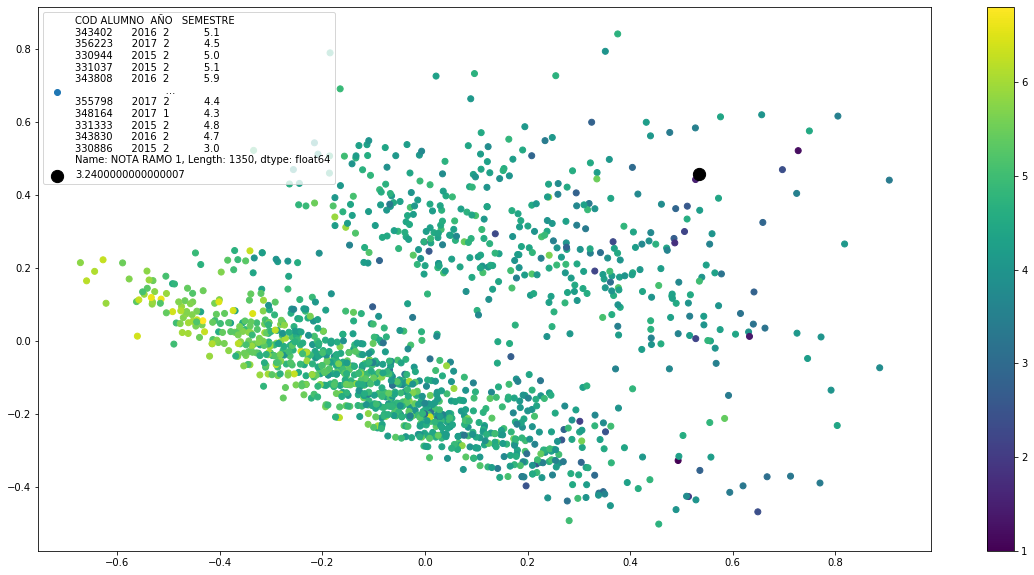

In [71]:
graficar(knn_pca)

## Mejor Clasificador

El mejor clasificador fue el modelo KNN Clasificador **sin datos categóricos** con más peso en los **créditos previos**.

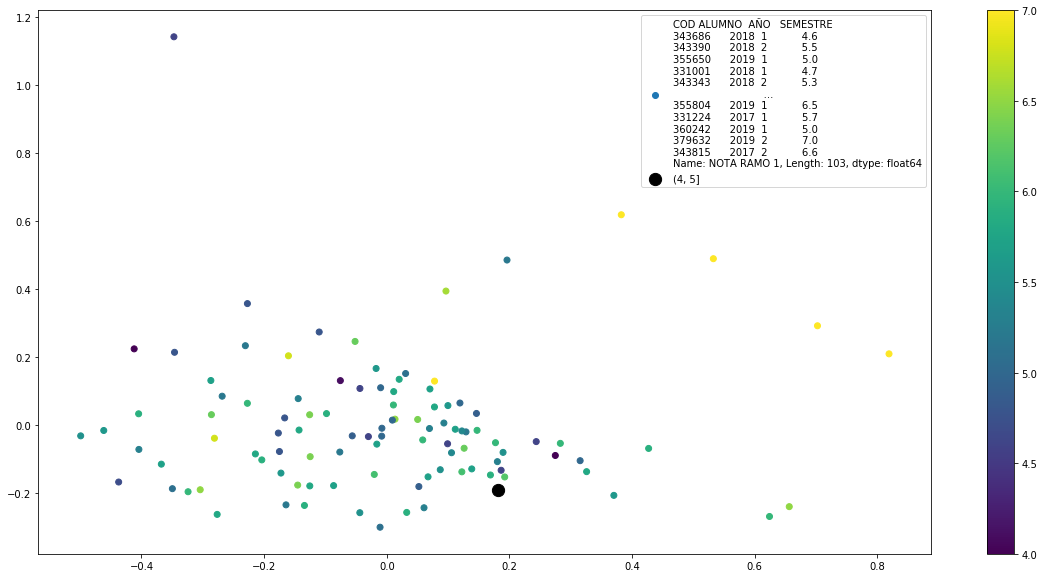

In [73]:
graficar(knn_pca_2)